<a href="https://colab.research.google.com/github/danielsaggau/LDSI_Project/blob/master/Generating_Legal_Text_with_Distil_GPT2_based_on_raw_Courtlistener_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if os.environ.get("COLAB_GPU", False):
    !pip install -U datasets transformers
import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from datasets import Dataset, load_dataset
import re
import json
import io
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras import activations, optimizers, losses
from spacy.lang.en import English
from spacy.attrs import ORTH
from tensorflow import keras

     |████████████████████████████████| 264 kB 5.4 MB/s 
     |████████████████████████████████| 2.6 MB 28.2 MB/s 
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 118 kB 36.0 MB/s 
     |████████████████████████████████| 243 kB 67.9 MB/s 
     |████████████████████████████████| 895 kB 49.6 MB/s 
     |████████████████████████████████| 636 kB 53.2 MB/s 
     |████████████████████████████████| 3.3 MB 17.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
random.seed(1)

In [2]:
pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
# Log Level and suppress extensive tf warnings
os.environ["TRANSFORMERS_VERBOSITY"] = "info"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(transformers.__version__)
PATH_BASE ="/content"

2.6.0
4.9.2


In [ ]:
data = pd.read_pickle("/Users/danielsaggau/PycharmProjects/pythonProject/data/opinions_data.pkl")
#subset to data that also entails actual opinions; remove page count = 0 / NaN
data = data[~data['page_count'].isnull()] # remove empty pages

text = data['plain_text']
author = data['author']
url = data['download_url']
html = data['html']
id = data['id']

text = data['plain_text'] # subset
# cleaning text file
text = text.replace("plain_text", " ")
text = text.replace("  ", " ")

text = text.str.replace("\n"," ")
text = text.str.replace("FILED", "")
text = text.str.replace("NOT FOR PUBLICATION", "")
text = text.str.replace("FOR PUBLICATION", "")
text = text.str.replace("UNITED STATES COURT OF APPEALS", "")
text = text.str.replace("U.S. COURT OF APPEALS", "")
text = text.str.replace("U .S. COURT OF APPEALS", "")
text = text.str.replace("U .S. COURT OF APPEALS", "")
text = text.str.replace("UNITED STATES OF AMERICA", "")
text = text.str.replace("\x0c","")
text = text.str.replace("\uf8fc","")
text = text.str.replace("\uf8fd","")
text = text.str.replace("\uf8fe", " ")
text = text.str.replace("FOR THE NINTH CIRCUIT", "")
text = text.str.replace("Appeal from the United States District Court", "")
text = text.str.replace("[*]","")
text = text.str.replace("\*\*","")
text = text.str.replace("\n\n","")
text = text.str.replace("MOLLY C. DWYER, CLERK", " ")
text = text.str.replace("U .S. C O U R T OF APPE ALS", " ")
text = text.str.replace("  ", " ")
data['length'] = text.str.len()


text.to_csv('/Users/danielsaggau/PycharmProjects/pythonProject/data/output.txt', sep='\n', index=False)

In [ ]:
# removing xml markup, symbols and starting text
text = open("/Users/danielsaggau/PycharmProjects/pythonProject/data/output.txt", "r").read()

nlp = English()
nlp.add_pipe("sentencizer")

# adding special tokens
nlp.tokenizer.add_special_case('§.', [{ORTH: '§.'}])
nlp.tokenizer.add_special_case('Cir.', [{ORTH: 'Cir.'}])
nlp.tokenizer.add_special_case('Fed.', [{ORTH: 'Fed.'}])
nlp.tokenizer.add_special_case('NO.', [{ORTH: 'NO.'}])
nlp.tokenizer.add_special_case('App.', [{ORTH: 'App.'}])
nlp.tokenizer.add_special_case('Civ.', [{ORTH: 'Civ.'}])
nlp.tokenizer.add_special_case('No.', [{ORTH: 'No.'}])
nlp.tokenizer.add_special_case('Dkt.', [{ORTH: 'Dkt.'}])
nlp.tokenizer.add_special_case('et al.', [{ORTH: 'et al.'}])
nlp.tokenizer.add_special_case('D.C.', [{ORTH: 'D.C.'}])
nlp.tokenizer.add_special_case('No.', [{ORTH: 'No.'}])
nlp.tokenizer.add_special_case('Nos.', [{ORTH: 'Nos.'}])
nlp.tokenizer.add_special_case('Fed.', [{ORTH: 'Fed.'}])
nlp.tokenizer.add_special_case('U.S.C.', [{ORTH: 'U.S.C.'}])
nlp.tokenizer.add_special_case(' F.', [{ORTH: 'F.'}])
nlp.tokenizer.add_special_case(' R.', [{ORTH: 'R.'}])
nlp.tokenizer.add_special_case(' P.', [{ORTH: 'P.'}])
nlp.tokenizer.add_special_case(' n.', [{ORTH: ' n.'}])
nlp.tokenizer.add_special_case(' v.', [{ORTH: ' v.'}]) # versus
nlp.tokenizer.add_special_case('Univ.', [{ORTH: 'Univ.'}])
nlp.tokenizer.add_special_case('Jr.', [{ORTH: 'Jr.'}])
nlp.tokenizer.add_special_case('I.N.S.', [{ORTH: 'I.N.S.'}])
nlp.tokenizer.add_special_case('OR.', [{ORTH: 'OR.'}])
nlp.tokenizer.add_special_case('REV.', [{ORTH: 'REV.'}])
nlp.tokenizer.add_special_case('STAT.', [{ORTH: 'STAT.'}])
doc = nlp(text[:1000000])
sentences = list(sents.text for sents in doc.sents) # ensure that we get strings and not spans

In [ ]:
batch = []
for sent in sentences:
    sent_new = " ".join([sent, '<eos>'])
    batch.append(sent_new)

Test and sanity check

In [ ]:
batch[:100]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
RE_SPLITTER = '<eos>'

MODEL_MAX_LEN = 256 # needs to be corrected

sent= []

In [ ]:
# code for this chunk stems from the huggingface forum
def chunk_text(text, num_tok):
    text_sent = \
        [sent.strip() + '.' for sent in re.split(RE_SPLITTER, text) if len(sent) > 1]

    # calculate number of tokens per sentence
    num_tok_sent = [len(tokenizer.tokenize(sent)) for sent in text_sent]

    # calculate chunk dimension to fit into model
    n = int(np.ceil(num_tok / MODEL_MAX_LEN))
    len_chunk = int(num_tok / n)

    # get a more uniform splitting to avoid splits
    # which are too short at the end
    if len_chunk + 50 > MODEL_MAX_LEN:
        len_chunk = int(num_tok / (n + 1))

    len_curr = 0
    text_curr = []
    text_chunk = []
    for te, len_sent in zip(text_sent, num_tok_sent):

        if len_curr + len_sent < len_chunk:
            text_curr.append(te)
            len_curr += len_sent

        elif len_curr + len_sent >= MODEL_MAX_LEN:
            text_chunk.append(text_curr)

            text_curr = [te]
            len_curr = len_sent

        else:  # >= len_chunk && < MODEL_MAX_LEN
            text_curr.append(te)
            text_chunk.append(text_curr)

            text_curr = []
            len_curr = 0

    if len_curr > 0:
        text_chunk.append(text_curr)

    return text_chunk

In [ ]:
joined = ''.join(b)
chunky = chunk_text(joined, 256)

flat_list = [''.join(x) for x in chunky]

#with open("data/chunks.txt", "r") as fp:
#    b = json.load(fp)
with open("data/sentence_chunks.json", "w") as fp:
#    json.dump(chunky, fp)
with open("data/flat_list.json", "w") as fp:
    json.dump(flat_list, fp)

In [3]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  ['10.15.133.178:8470']
REPLICAS:  8


In [5]:
data = pd.read_json('/content/flat_list.json')
data.to_csv("/content/data.csv", index=False)

In [6]:
data[80:100]

,0
80,"see also Cook, 593 F.3d at 817–18 (holding that the prosecutor’s justification for striking a juror was “not clearly pretextual” because “it is plausible that daily contact with lawyers would shape a person’s perception of a trial”)..Concern that a juror might have reason to sympathize or identify with the defendant, regardless of whether the identifying feature relates to the merits of the case, is “relevant” under Batson..See, e.g., Rice, 546 U.S. at 341 (upholding age, single status, and lack of ties to the community as valid bases to exclude a juror in a drug case because they might make the juror more sympathetic to the defendant);."
81,"Williams v. Rhoades, 354 F.3d 1101, 1109–10 (9th Cir. 2004) (fear that a juror might identify with the defendant because both had young sons was a valid, race- neutral reason to exercise a peremptory strike);.see also United States v. Brown, 560 F.3d 754, 763 (8th Cir. 2009) (upholding the strike of a prospective juror from a murder trial because both the juror and the defendant received public assistance and the juror might identify with the defendant on that basis)..Thus, in this case, the prosecutor’s fear that Juror #4856 might identify with Jamerson because both suffered from a physical ailment qualifies as relevant in the sense Batson contemplates.."
82,"JAMERSON V ..RUNNELS 19 The magistrate judge’s related concern about “the record [being] devoid of anything suggesting that suffering from hepatitis would make [the juror] inherently sympathetic toward petitioner,” failed to take into account the proper burden of proof and to afford appropriate deference to the state courts..The prosecutor need not establish with evidence on the record that her voir dire instincts are objectively correct;.instead, the defendant must show that the prosecutor’s reasons are not subjectively genuine..Rice, 546 U.S. at 338 (citing Purkett, 514 U.S. at 768);."
83,"Kesser, 465 F.3d at 359 (quoting Hernandez, 500 U.S. at 365)..Though hepatitis and a leg disability are not identical—or even closely related—medical conditions, both are permanent physical ailments that impact a person’s everyday life in a significant way..The state appellate court was not unreasonable to believe that the prosecutor genuinely saw these permanent conditions as a shared experience between the defendant and the juror, which might give rise to empathy and bias, especially when viewed through our doubly deferential lens..Second, the magistrate judge believed that “[t]he fact that the prosecutor did not ask [the juror] any questions about his illness confirms that her reason was pretextual.”."
84,"An examination of the record belies this conclusion..Throughout the entire voir dire process, the court—and not the attorneys—conducted the questioning of the jurors..The prosecutor’s failure to question a juror cannot be held against her when attorney questioning did not occur during voir dire.6 6 The magistrate judge proffered this same reason as one basis for rejecting the prosecutor’s justifications for striking Juror #0970, Juror #0619, and Juror #3117D, as well..W e conclude that he was incorrect in considering this as evidence of discriminatory intent in each instance.."
85,"20 JAMERSON V ..RUNNELS See Miller-El II, 545 U.S. at 243–44 (finding that a prosecutor’s failure to question a juror further was evidence of a discriminatory motive where the prosecutor was personally questioning the jurors at length during voir dire)..In sum, even though the prosecutor’s reason for excusing the juror may not have been compelling and “[r]easonable minds reviewing the record might disagree about the prosecutor’s credibility,” there is not sufficient evidence to “supersede the trial court’s credibility determination” under our doubly deferential standard of review.."
86,"Rice, 546 U.S. at 341–42..Thus, we conclude that the state was not unreasonable in finding that the prosecutor’s justification for challenging Juror #4856 was genuine..2 Ju

In [7]:
data = pd.read_csv("/content/data.csv")
data = Dataset.from_pandas(data)
data.rename_column("0", "text")

Dataset({
    features: ['text'],
    num_rows: 1668
})

# tokenizer
We need to instantiate the tokenizer and also add some special tokens, as done with spacy. 

In [8]:
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"
MAX_TOKENS = 128 # was 128

tokenizer = AutoTokenizer.from_pretrained(
    "gpt2",
    eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

# adding further special cases
special_cases = ['Cir.','Fed.','No.','NO','App.','Civ.', 'Dkt.', 'et al.','Nos.','U.S.C.','F.',
                 'R.', 'n.', 'v.', 'Univ.', 'Jr.','I.N.S.', 'OR.', 'REV.', 'STAT.','D.C.']

tokenizer.add_tokens(special_cases, special_tokens = False)


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


20

Map Tokenizer to data 

In [9]:
output = {}

# defining tokenizer function
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["0"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True, 
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction & set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

In [10]:
data = data.map(
    tokenize_function,
    batched=True,
    num_proc=strategy.num_replicas_in_sync,
    remove_columns=["0"],
    load_from_cache_file=True,
)
data.save_to_disk("/content/dataset_format")
data = datasets.load_from_disk("/content/dataset_format")
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])
data = data.train_test_split(
    test_size=0.20, shuffle=True, seed=1, load_from_cache_file=True
)

In [11]:
# convert to tensors and split data
train_tensor_inputs = tf.convert_to_tensor(data["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(data["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

In [ ]:
test_tensor_inputs = tf.convert_to_tensor(data["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(data["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(data["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

In [20]:
BATCH_SIZE_PER_REPLICA = 28
EPOCHS = 8
INITAL_LEARNING_RATE = 0.0001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)

In [21]:
# reference note: prepare data for consumption
train_ds = (train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True))
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

# reference note: Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.7,
    staircase=True)
# reference note: initialize model, use_cache=False important! else wrong shape at loss calc
with strategy.scope():
    model = TFGPT2LMHeadModel.from_pretrained(
        "distilgpt2",
        use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    model.resize_token_embeddings(len(tokenizer))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=model.compute_loss)
    model.summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  81928704  
Total params: 81,928,704
Trainable params: 81,928,704
Non-trainable params: 0
_________________________________________________________________


In [22]:
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)

Model Params:
batch_size: 224
Epochs: 8
Step p. Epoch: 5
Initial Learning rate: 0.0001


In [23]:
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=8,
    verbose=1,
)

Epoch 1/8
5/5 [==============================] - 52s 2s/step - loss: 23.0046 - val_loss: 7.1466
Epoch 2/8
5/5 [==============================] - 3s 786ms/step - loss: 7.1718 - val_loss: 6.9701
Epoch 3/8
5/5 [==============================] - 3s 649ms/step - loss: 6.8407 - val_loss: 6.4122
Epoch 4/8
5/5 [==============================] - 3s 627ms/step - loss: 6.3013 - val_loss: 5.8781
Epoch 5/8
5/5 [==============================] - 3s 635ms/step - loss: 5.8390 - val_loss: 5.3800
Epoch 6/8
5/5 [==============================] - 3s 638ms/step - loss: 5.3742 - val_loss: 4.9669
Epoch 7/8
5/5 [==============================] - 3s 632ms/step - loss: 5.0267 - val_loss: 4.7072
Epoch 8/8
5/5 [==============================] - 3s 644ms/step - loss: 4.7645 - val_loss: 4.5540


In [ ]:
# save model
hist.save("model")

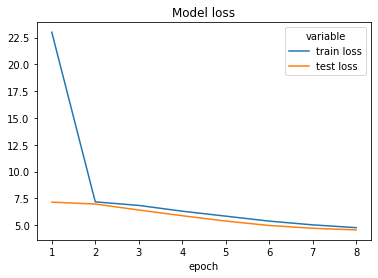

In [24]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

# load model

In [126]:
from transformers import pipeline

gen = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [135]:
text = 'Without reciting all of the details of his efforts we note that the 90-day period for filing a complaint expired on May 14, 1973.'
text = str(text)

In [136]:
gen(text, max_length=80, num_return_sequences=10, return_full_text=None)

[{'generated_text': "Without reciting all of the details of his efforts we note that the 90-day period for filing a complaint expired on May 14, 1973. No-one else was indicted in this case. The defendant was convicted of filing or filing an action against the defendant. The defendant is eligible to continue the complaint and review the complaint's appeal, and review the complaint's charges to be dismissed, the case"},
 {'generated_text': 'Without reciting all of the details of his efforts we note that the 90-day period for filing a complaint expired on May 14, 1973. This incident occurred on April 28, 1977. As was not sufficient to justify the filing at the conclusion that the 90-day period for filing a complaint expired on April 20, 2000. The 90-day record was changed, the evidence and argument on the'},
 {'generated_text': 'Without reciting all of the details of his efforts we note that the 90-day period for filing a complaint expired on May 14, 1973.\nWhile I was not responsible for

In [ ]:
!pip install spacy-readability
import spacy
from spacy_readability import Readability

In [38]:
nlp = spacy.load('en')
read = Readability()
nlp.add_pipe(read, last=True)

In [50]:
text = gen[1]
text = str(text)

In [51]:
doc = nlp(text)

print(doc._.flesch_kincaid_grade_level)
print(doc._.flesch_kincaid_reading_ease)

14.188831168831168
39.05086580086581


In [53]:
text = str(gen[2])
doc = nlp(text)

print(doc._.flesch_kincaid_grade_level)
print(doc._.flesch_kincaid_reading_ease)

16.7491095890411
39.990239726027426


In [54]:
text = str(gen[3])
doc = nlp(text)

print(doc._.flesch_kincaid_grade_level)
print(doc._.flesch_kincaid_reading_ease)

17.17783783783784
37.80702702702703


In [55]:
text = str(gen[4])
doc = nlp(text)

print(doc._.flesch_kincaid_grade_level)
print(doc._.flesch_kincaid_reading_ease)

20.11766666666667
17.62050000000002


In [58]:
text = str(gen[7])
doc = nlp(text)

print(doc._.flesch_kincaid_grade_level)
print(doc._.flesch_kincaid_reading_ease)

12.096
52.86800000000002


In [62]:
gen[9]
text = str(gen[9])
doc = nlp(text)

print(doc._.flesch_kincaid_grade_level)
print(doc._.flesch_kincaid_reading_ease)

16.128896103896107
47.999058441558475


In [121]:
gen

[{'generated_text': "Appellant urges that he acted diligently to present his claim to the court and that this diligence should justify the one-day delay and relief for a court complaint to judge that he provided the purpose of the appeal, in the case of the complaint, was not authorized by Defendant Richard Wright. [9] The court was not authorized by Defendant Lawrence M. Wilson to appeal the Court's decision to judge"},
 {'generated_text': "Appellant urges that he acted diligently to present his claim to the court and that this diligence should justify the one-day delay and judgment of his court's court.\n\n\nA jury unanimously concluded that an erroneous sentence was to be imposed on all the defendants to do so.\nThe jury agreed that defendants were guilty of the crime.\nThe jury found that defendant was guilty of the conviction"},
 {'generated_text': 'Appellant urges that he acted diligently to present his claim to the court and that this diligence should justify the one-day delay a